In [40]:
import math
class Value:
    """ stores a single scalar value and its gradient """

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0
        self.label = label
        # internal variables used for autograd graph construction
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op # the op that produced this node, for graphviz / debugging / etc

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward

        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += (other * self.data**(other-1)) * out.grad
        out._backward = _backward

        return out

    def relu(self):
        out = Value(0 if self.data < 0 else self.data, (self,), 'ReLU')

        def _backward():
            self.grad += (out.data > 0) * out.grad
        out._backward = _backward

        return out
    
    def sigmoid(self):
        out = Value(1 / (1 + (math.e)**(-1*self.data)), (self, ), "Sigmoid") 

        def _backward():
            self.grad += (out.data * (1 - out.data)) * out.grad
        out._backward = _backward
        return out

    def backward(self):

        # topological order all of the children in the graph
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        # go one variable at a time and apply the chain rule to get its gradient
        self.grad = 1
        for v in reversed(topo):
            v._backward()

    def __neg__(self): # -self
        return self * -1

    def __radd__(self, other): # other + self
        return self + other

    def __sub__(self, other): # self - other
        return self + (-other)

    def __rsub__(self, other): # other - self
        return other + (-self)

    def __rmul__(self, other): # other * self
        return self * other

    def __truediv__(self, other): # self / other
        return self * other**-1

    def __rtruediv__(self, other): # other / self
        return other * self**-1

    def __repr__(self):
        return f"Value(data={self.data}, grad={self.grad})"


In [31]:

import os

# Voeg de map van 'dot' toe aan PATH binnen Python
os.environ["PATH"] += os.pathsep + "/opt/local/bin"

# Daarna pas graphviz gebruiken
from graphviz import Digraph

In [38]:
def trace(root):
    # build a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={"rankdir": "LR"}) # LR is left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectengular node for it

        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4r }" % (n.label, n.data, n.grad), shape="record")
        if n._op:
            # if this value is a result of some operation then create a op node 
            dot.node(name = uid + n._op, label = n._op)
            # and connect the node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    return dot

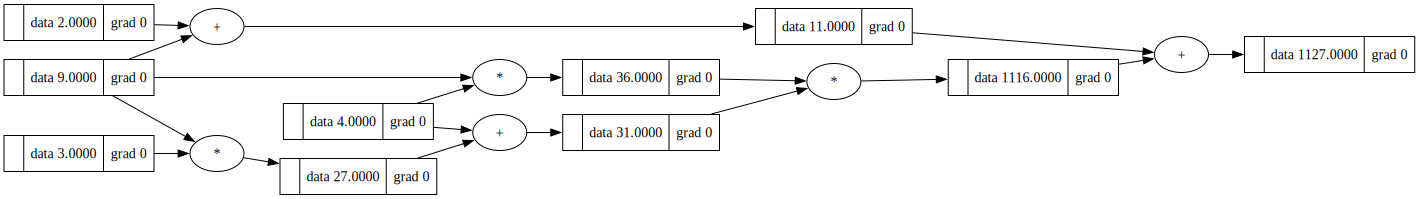

In [59]:
a = Value(2)
b = Value(9)
c = Value(4)
d = Value(3)
e = Value(3)
f = Value(6)
x1 = a + b
x2 = b * c
x3 = c + b * d
x4 = e + f
o = x1 + x2 * x3
draw_dot(o)

In [114]:
import random
class Module:

    def zero_grad(self):
        for p in self.parameters():
            p.grad = 0

    def parameters(self):
        return []

class Neuron(Module):

    def __init__(self, nin, activation_function):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(0)
        self.activation_function = activation_function

    def __call__(self, x):
        act = sum((wi*xi for wi,xi in zip(self.w, x)), self.b)
        if self.activation_function == 'relu':
            return act.relu()
        elif self.activation_function == 'sigmoid':
            return act.sigmoid()
        else:
            return act

    def parameters(self):
        return self.w + [self.b]

    def __repr__(self):
        if self.activation_function == 'relu':
            return f"Relu Neuron({len(self.w)})"
        elif self.activation_function == 'sigmoid':
            return f"Sigmoid Neuron({len(self.w)})"
        else:
            return f"Neuron({len(self.w)})"

class Layer(Module):

    def __init__(self, nin, nout, activation_function):
        self.neurons = [Neuron(nin, activation_function) for _ in range(nout)]

    def __call__(self, x):
        out = [n(x) for n in self.neurons]
        return out[0] if len(out) == 1 else out

    def parameters(self):
        return [p for n in self.neurons for p in n.parameters()]

    def __repr__(self):
        return f"Layer of [{', '.join(str(n) for n in self.neurons)}]"

class MLP(Module):

    def __init__(self, nin, nouts, activation_function):
        sz = [nin] + nouts
        #self.activation_function = activation_function
 
        self.layers = [Layer(sz[i], sz[i+1], activation_function=activation_function if i != len(nouts) -1 else None) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

    def __repr__(self):
        return f"MLP of [{', '.join(str(layer) for layer in self.layers)}]"


MLP of [Layer of [Sigmoid Neuron(3), Sigmoid Neuron(3), Sigmoid Neuron(3), Sigmoid Neuron(3), Sigmoid Neuron(3)], Layer of [Sigmoid Neuron(5), Sigmoid Neuron(5), Sigmoid Neuron(5), Sigmoid Neuron(5), Sigmoid Neuron(5)], Layer of [Neuron(5)]]


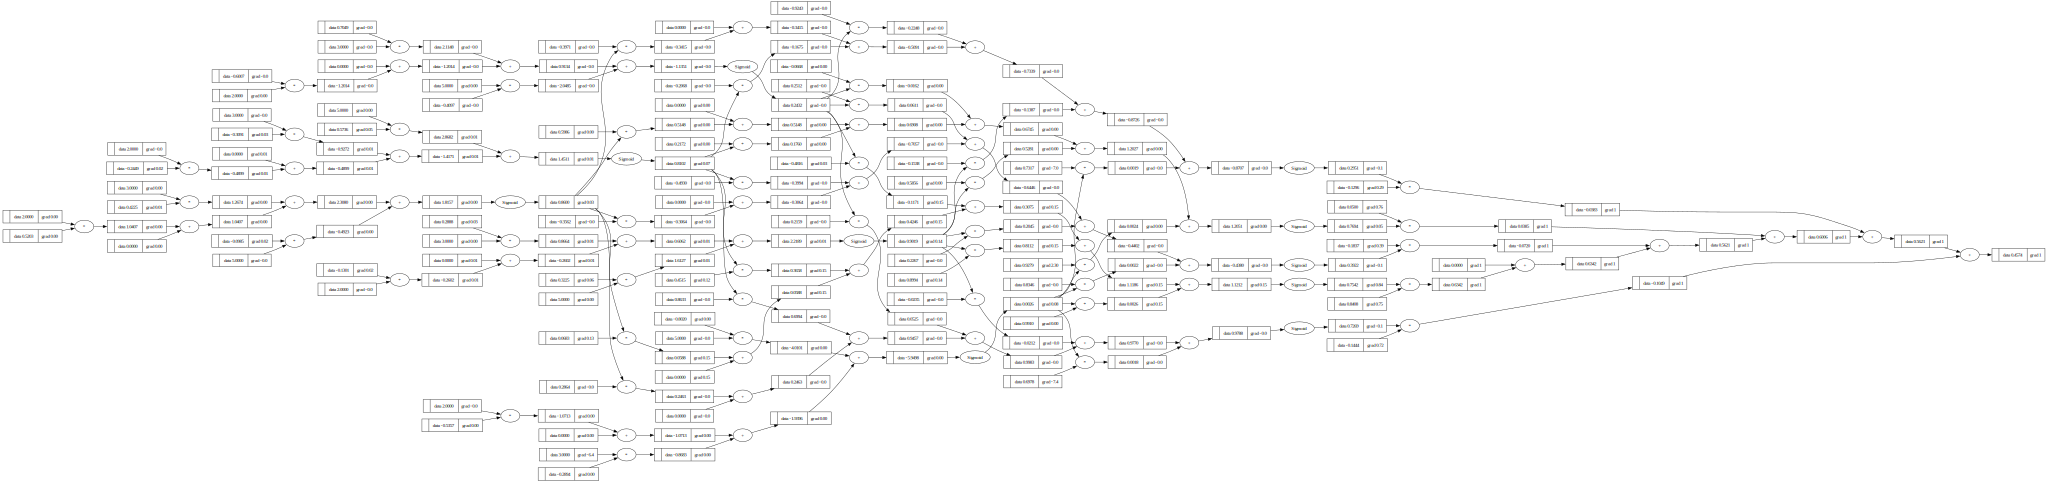

In [115]:
nn = MLP(3, [5, 5, 1], activation_function='sigmoid')
#nn = Layer(3, 1, activation_function=None)
data = [2.0, 3.0, 5.0]
model = nn(data)
print(nn)
model.backward()
draw_dot(model)